In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [12]:
df = pd.read_csv('../data/preprocessed/main-data.csv') 

# convert day to numerical
df = pd.get_dummies(df, columns=['day'])

df.drop(['category_names'], axis=1, inplace=True)

# Define features and target variable
X = df[df.columns.difference(['collection_duration'])].astype(int)
y = df['collection_duration']


# # Reshape X for LSTM
X = X.values.reshape(X.shape[0], 1, X.shape[1])


In [13]:
# Split df into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape , X_test.shape

((1098821, 1, 34), (274706, 1, 34))

In [14]:
# Split the training set into training and validation sets 60% training, 20% validation
'''If we want to use validation set do the following:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
'''

'If we want to use validation set do the following:\nX_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)\n'

In [15]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Train the model with EarlyStopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Loss:", loss)

predictions = model.predict(X_test)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27471/27471 ━━━━━━━━━━━━━━━━━━━━ 14s 497us/step - loss: 4.5170 - val_loss: 4.5820
Epoch 2/100
27471/27471 ━━━━━━━━━━━━━━━━━━━━ 13s 459us/step - loss: 4.0567 - val_loss: 4.4166
Epoch 3/100
27471/27471 ━━━━━━━━━━━━━━━━━━━━ 13s 477us/step - loss: 4.0453 - val_loss: 4.2324
Epoch 4/100
27471/27471 ━━━━━━━━━━━━━━━━━━━━ 14s 497us/step - loss: 4.0436 - val_loss: 4.3370
Epoch 5/100
27471/27471 ━━━━━━━━━━━━━━━━━━━━ 13s 461us/step - loss: 4.0456 - val_loss: 4.3757
Epoch 6/100
27471/27471 ━━━━━━━━━━━━━━━━━━━━ 13s 476us/step - loss: 4.0394 - val_loss: 4.2165
Epoch 7/100
27471/27471 ━━━━━━━━━━━━━━━━━━━━ 13s 462us/step - loss: 4.0373 - val_loss: 4.3644
Epoch 8/100
27471/27471 ━━━━━━━━━━━━━━━━━━━━ 13s 455us/step - loss: 4.0336 - val_loss: 4.2446
Epoch 9/100
27471/27471 ━━━━━━━━━━━━━━━━━━━━ 13s 466us/step - loss: 4.0425 - val_loss: 4.3170
Epoch 10/100
27471/27471 ━━━━━━━━━━━━━━━━━━━━ 13s 460us/step - loss: 4.0298 - val_loss: 4.2284
Epoch 11/100
27471/27471 ━━━━━━━━━━━━━━━━━━━━ 13s 461us/step - loss: 4.

In [16]:
# Evaluate predictions
rmse = root_mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rsquared = r2_score(y_test, predictions)

print("RMSE:", rmse)
print("MAE:", mae)
print("R^2:", rsquared)
p_accuracy = [(1 - np.abs(pred - actual) / actual) * 100 for pred, actual in zip(predictions, y_test)]

# Print P_accuracy
print("P_accuracy: Mean: %.2f%%, Min: %.2f%%, Max: %.2f%%" % (np.mean(p_accuracy), np.min(p_accuracy), np.max(p_accuracy)))

RMSE: 2.0543517916554896
MAE: 1.5826452106342752
R^2: 0.31916964809856596
P_accuracy: Mean: 70.58%, Min: -71.36%, Max: 100.00%


In [17]:
min_index = np.argmin(p_accuracy)
max_index = np.argmax(p_accuracy)
min_p_accuracy = p_accuracy[min_index]
corresponding_pred = predictions[min_index,0]
corresponding_actual = y_test.iloc[min_index]

print("Minimum P_accuracy:", min_p_accuracy[0],"%")
print("Corresponding Prediction:", corresponding_pred)
print("Corresponding Actual Value:", corresponding_actual)

Minimum P_accuracy: -71.35714 %
Corresponding Prediction: 4.2060356
Corresponding Actual Value: 1.55


In [18]:
less_than_zero = [p_acc for p_acc in p_accuracy if p_acc < 0]
more_than_zero = [p_acc for p_acc in p_accuracy if p_acc > 0]

count_less_than_zero = len(less_than_zero)
count_more_than_zero = len(more_than_zero)

print(f"The total {count_more_than_zero} values are greater than 0%.")
print(f"The total {count_less_than_zero} values are less than 0%.")

The total 272531 values are greater than 0%.
The total 2175 values are less than 0%.


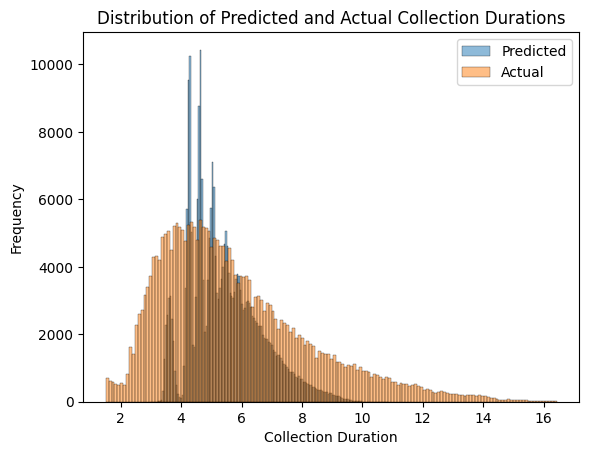

In [19]:
# Plot the distribution of predicted values

sns.histplot(predictions, alpha=0.5, label='Predicted')
sns.histplot(y_test, alpha=0.5, label='Actual')

plt.xlabel('Collection Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted and Actual Collection Durations')
plt.legend()
plt.show()

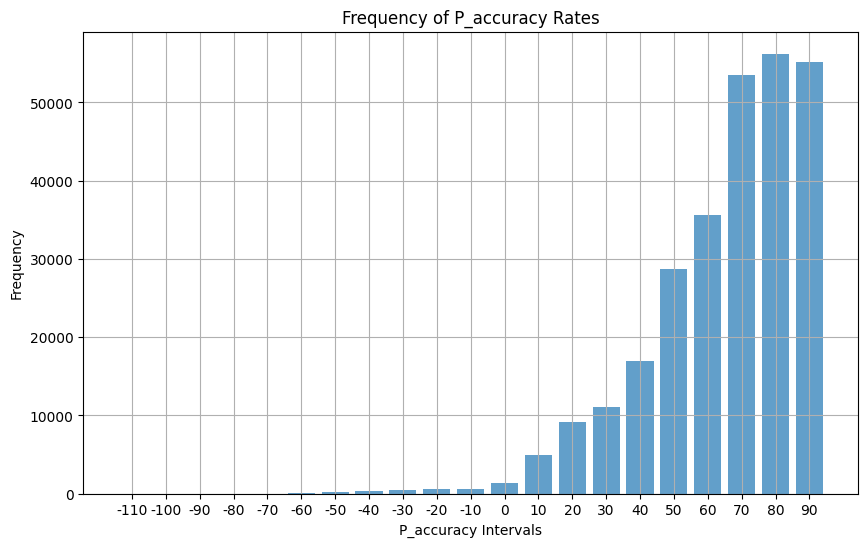

----------------------------------------------------------------------------------------
Interval: [-110%, -100%] - Frequency: 0
Interval: [-100%, -90%] - Frequency: 0
Interval: [-90%, -80%] - Frequency: 0
Interval: [-80%, -70%] - Frequency: 1
Interval: [-70%, -60%] - Frequency: 2
Interval: [-60%, -50%] - Frequency: 33
Interval: [-50%, -40%] - Frequency: 156
Interval: [-40%, -30%] - Frequency: 380
Interval: [-30%, -20%] - Frequency: 433
Interval: [-20%, -10%] - Frequency: 551
Interval: [-10%, 0%] - Frequency: 619
Interval: [0%, 10%] - Frequency: 1302
Interval: [10%, 20%] - Frequency: 4928
Interval: [20%, 30%] - Frequency: 9107
Interval: [30%, 40%] - Frequency: 11012
Interval: [40%, 50%] - Frequency: 16929
Interval: [50%, 60%] - Frequency: 28748
Interval: [60%, 70%] - Frequency: 35598
Interval: [70%, 80%] - Frequency: 53509
Interval: [80%, 90%] - Frequency: 56231
Interval: [90%, 100%] - Frequency: 55167


In [20]:
#Scatter plots showing the frequency similarity from –100 to 100 by 10 percent intervals

# Define the intervals
intervals = np.arange(-110, 110, 10)

# Count the frequency of p_accuracy within each interval
frequency = []
for i in range(len(intervals)-1):
    count = ((p_accuracy >= intervals[i]) & (p_accuracy < intervals[i+1])).sum()
    frequency.append(count)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(intervals)-1), frequency, align='center', alpha=0.7)
plt.xticks(np.arange(len(intervals)-1), intervals[:-1])
plt.xlabel('P_accuracy Intervals')
plt.ylabel('Frequency')
plt.title('Frequency of P_accuracy Rates')
plt.grid(True)
plt.show()
print("----------------------------------------------------------------------------------------")
for i in range(len(intervals)-1):
    print("Interval: [%d%%, %d%%] - Frequency: %d" % (intervals[i], intervals[i+1], frequency[i]))